In [1]:
import sys; sys.argv=['']; del sys

In [2]:
from __future__ import division
import time
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from jacobian import JacobianReg
import numpy as np

from models.lenet import *
from models.resnet import *
from models.vgg import *
from models.mlp import *

from logger import get_logger
from option import Options

import matplotlib.pyplot as plt

args = Options().parse()

In [3]:
args.defense = "rand_size"
# args.defense = None

In [4]:
from advertorch.attacks import GradientSignAttack
from advertorch.attacks import PGDAttack

In [5]:
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.manual_seed(args.seed)
else:
    device = torch.device("cpu")

In [6]:
def eval(device, model, loader, criterion, lambda_JR):
    '''
    Evaluate a model on a dataset for Jacobian regularization
    Arguments:
        device (torch.device): specifies cpu or gpu training
        model (nn.Module): the neural network to evaluate
        loader (DataLoader): a loader for the dataset to eval
        criterion (nn.Module): the supervised loss function
        lambda_JR (float): the Jacobian regularization weight
    Returns:
        correct (int): the number correct
        total (int): the total number of examples
        loss_super (float): the supervised loss
        loss_JR (float): the Jacobian regularization loss
        loss (float): the total combined loss
    '''

    correct = 0
    total = 0 
    loss_super_avg = 0 
    loss_JR_avg = 0 
    loss_avg = 0

    # for eval, let's compute the jacobian exactly
    # so n, the number of projections, is set to -1.
    reg_full = JacobianReg(n=-1)
    for data, targets in loader:
        data = data.to(device)
        
        data.requires_grad = True # this is essential!
        targets = targets.to(device)
        output = model(data)
        _, predicted = torch.max(output, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
        loss_super = criterion(output, targets) # supervised loss
        loss_JR = reg_full(data, output) # Jacobian regularization
        loss = loss_super + args.lambda_JR*loss_JR # full loss
        loss_super_avg += loss_super.data*targets.size(0)
        loss_JR_avg += loss_JR.data*targets.size(0)
        loss_avg += loss.data*targets.size(0)

    loss_super_avg /= total
    loss_JR_avg /= total
    loss_avg /= total
    return correct, total, loss_super, loss_JR, loss

In [7]:
mnist_mean = (0.1307,)
mnist_std = (0.3081,)

    
transform = transforms.Compose(
    [
    transforms.ToTensor(), 
     #transforms.Normalize(mnist_mean, mnist_std)
    ]
)
trainset = datasets.MNIST(root='./data', train=True, 
    download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=args.batch_size, shuffle=True
)
testset = datasets.MNIST(root='./data', train=False, 
    download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=args.batch_size, shuffle=True
)


In [8]:
model = LeNet_standard()
model.load_state_dict(torch.load('saved_models/'+'regularization-l2'+'.t7', map_location=lambda storage, loc: storage))
model = model.cuda()

# model = LeNet_standard()
# model.load_state_dict(torch.load('saved_models/'+'jr-proj1'+'.t7', map_location=lambda storage, loc: storage))
# model = model.cuda()

In [9]:
criterion = nn.CrossEntropyLoss()

### attack

In [10]:
def eval_attack(device, model, loader, criterion, lambda_JR, adversary):
    '''
    Evaluate a model on a dataset for Jacobian regularization
    Arguments:
        device (torch.device): specifies cpu or gpu training
        model (nn.Module): the neural network to evaluate
        loader (DataLoader): a loader for the dataset to eval
        criterion (nn.Module): the supervised loss function
        lambda_JR (float): the Jacobian regularization weight
    Returns:
        correct (int): the number correct
        total (int): the total number of examples
        loss_super (float): the supervised loss
        loss_JR (float): the Jacobian regularization loss
        loss (float): the total combined loss
    '''

    correct = 0
    total = 0 
    loss_super_avg = 0 
    loss_JR_avg = 0 
    loss_avg = 0
    
    

    # for eval, let's compute the jacobian exactly
    # so n, the number of projections, is set to -1.
    reg_full = JacobianReg(n=-1)
    for data, targets in loader:
        
        data = data.to(device)
        targets = targets.to(device)
        
        ####
        # perturbation
        ####
        data_bad = torch.clamp(adversary.perturb(data, targets), 0, 1)
        
        #print(data.shape)
        
        ####
        # defense and preprocessing
        ####
        if args.defense != None:
            if args.defense == "rand_size":
                print('applying ' args.defense)
                
                new_W = np.random.randint(24, 28)
                new_H = np.random.randint(24, 28)
                padding_left = np.random.randint(0, 28 - new_W + 1)
                padding_right = 28 - new_W - padding_left
                padding_top = np.random.randint(0, 28 - new_H + 1) # left, top, right and bottom
                padding_bottom = 28 - new_H - padding_top
                #logger.info('Width: %d, height: %d, padding_left: %d, padding_right: %d, padding_top: %d, padding_bottom: %d' %
                #            (new_W, new_H, padding_left, padding_right, padding_top, padding_bottom)
                #    )
                transform_defense = transforms.Compose(
                    [transforms.Resize((new_H, new_W)), 
                     transforms.Pad((padding_left, padding_top, padding_right, padding_bottom)), 
                     transforms.ToTensor(), 
                     #transforms.Normalize(mnist_mean, mnist_std)
                    ]
                )
            else:
                print("Invalid defense name.")
                raise
                
        
        
        
        
        data = (data - mnist_mean[0])/mnist_std[0]
        data_bad = (data_bad - mnist_mean[0])/mnist_std[0]
        

        output = model(data_bad)
        _, predicted = torch.max(output, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    return correct, total, data, data_bad

In [11]:
adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(), 
    eps=0.2,
    targeted=False)

# adversary = PGDAttack(
#     model, loss_fn=nn.CrossEntropyLoss(), 
#     nb_iter=20,
#     targeted=False)

In [12]:
correct_f, total, loss_super_f, loss_JR_f, loss_f = eval(
        device, model, testloader, criterion, args.lambda_JR
    )

print('Before attack:')
print('accuracy: %d/%d=%.3f' % (correct_f, total, correct_f/total))
print('supervised loss: %.3f' % loss_super_f)
print('Jacobian loss: %.3f' % loss_JR_f)
print('total loss: %.3f' % loss_f)

correct_f, total, ex, ex_bad = eval_attack(
        device, model, testloader, criterion, args.lambda_JR, adversary
    )

print("=========================================")
print('accuracy after attack: %d/%d=%.3f' % (correct_f, total, correct_f/total))

Before attack:
accuracy: 9830/10000=0.983
supervised loss: 0.244
Jacobian loss: 6.077
total loss: 0.852
accuracy after attack: 1409/10000=0.141


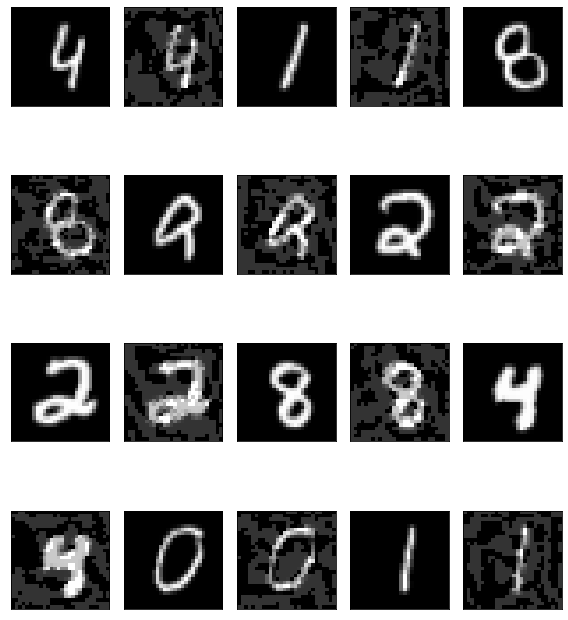

In [13]:
cnt = 0
plt.figure(figsize=(8,10))

for i in range(10):
    cnt += 1
    plt.subplot(4,5,cnt)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.imshow(ex[i].cpu().detach().numpy().squeeze(), cmap="gray")
    
    cnt += 1
    
    plt.subplot(4,5,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    
    plt.imshow(ex_bad[i].cpu().detach().numpy().squeeze(), cmap="gray")
plt.tight_layout()
plt.show()